# Goal: investigate code distance required to tolerate ray impact

In [1]:
import sys
sys.path.append('../')

import sinter
import matplotlib.pyplot as plt
import numpy as np
import pickle
import multiprocess as mp

from stim_surface_code.memory import MemoryPatch
from stim_surface_code.stability import StabilityPatch
from stim_lattice_surgery.lattice_surgery.single_error_metric import initialize_ops, get_processed_error_data
from stim_lattice_surgery.lattice_surgery.zxxz_patch import ZXXZPatch
from stim_lattice_surgery.lattice_surgery.glue import GluePatch, BoundaryType
from stim_lattice_surgery.lattice_surgery.surgery_op import SurgeryOp
from ray_delay.noise_model import NoiseModel, GoogleNoiseParamsNoRandomRays
from ray_delay.noise_model_patch import NoiseModelPatch
import qc_utils.matplotlib_setup as mpl_setup
import qc_utils.stats

In [2]:
mpl_setup.setup_default()
mpl_setup.set_colors(mpl_setup.nature_colors)

TODO: what about multiple rays? should we assume that you just add the added
distance again?

# Surface code memory experiment: ray in center

In [3]:
generate_data = False

In [4]:
if generate_data:
    radii_mem = [0,2,4,6,8]
    d_range_mem = [7,9,11,13,15,17]
    strengths_mem = [0.9, 0.99, 0.999]

    tasks_Z = []
    tasks_X = []
    for strength in strengths_mem:
        for d in d_range_mem:
            for r in radii_mem:
                noise_params = GoogleNoiseParamsNoRandomRays.improve(10)
                noise_params.cosmic_ray_params.max_strength = strength
                _patch = MemoryPatch(d, d, d)
                nmp = NoiseModelPatch(_patch, noise_params=noise_params)
                if r > 0:
                    nmp.force_cosmic_ray_by_coords((d//2, d//2), r)
                tasks_Z.append(nmp.patch.get_sinter_task({'json_metadata':{'d':d, 'r':r, 'strength':strength}}))
                tasks_X.append(nmp.patch.get_sinter_task({'json_metadata':{'d':d, 'r':r, 'strength':strength}}, observable_basis='X'))
    
    collected_results_memory_Z = sinter.collect(
        tasks=tasks_Z,
        num_workers=6,
        decoders=['pymatching'],
        max_shots=10**7,
        max_errors=1000,
    )
    print('Z done')
    collected_results_memory_X = sinter.collect(
        tasks=tasks_X,
        num_workers=6,
        decoders=['pymatching'],
        max_shots=10**7,
        max_errors=1000,
    )

    with open('data/code_expansion_distance_memory.pkl', 'wb') as f:
        pickle.dump({
            'radii': radii_mem,
            'distances': d_range_mem,
            'strengths': strengths_mem,
            'sinter_results_Z': collected_results_memory_Z,
            'sinter_results_X': collected_results_memory_X,
        }, f)
else:
    with open('data/code_expansion_distance_memory.pkl', 'rb') as f:
        data = pickle.load(f)
        radii_mem = data['radii']
        d_range_mem = data['distances']
        strengths_mem = data['strengths']
        collected_results_memory_Z = data['sinter_results_Z']
        collected_results_memory_X = data['sinter_results_X']

In [5]:
# for each distance, perform a linear fit to the error rate vs radius for r > 0.
# Find where this fit intersects the d=7 baseline (r = 0).
# Plot these intersections as a function of 

baseline_error_rates = np.zeros((len(strengths_mem), len(d_range_mem)))
ray_error_rates = np.zeros((len(strengths_mem), len(d_range_mem), len(radii_mem)-1))
combined_error_rates_mem = np.zeros((len(strengths_mem), len(radii_mem), len(d_range_mem)))
for strength_idx in range(len(strengths_mem)):
    for d_idx,d in enumerate(d_range_mem):
        selected_results_X = [x for x in collected_results_memory_X if x.json_metadata['d'] == d and x.json_metadata['strength'] == strengths_mem[strength_idx]]
        selected_results_Z = [x for x in collected_results_memory_Z if x.json_metadata['d'] == d and x.json_metadata['strength'] == strengths_mem[strength_idx]]

        radii_X = np.array([x.json_metadata['r'] for x in selected_results_X])
        selected_error_rates_X = np.array([x.errors / x.shots for x in selected_results_X])
        # sort by radius
        radii_X, selected_error_rates_X = zip(*sorted(zip(radii_X, selected_error_rates_X)))

        radii_Z = np.array([x.json_metadata['r'] for x in selected_results_Z])
        selected_error_rates_Z = np.array([x.errors / x.shots for x in selected_results_Z])
        # sort by radius
        radii_Z, selected_error_rates_Z = zip(*sorted(zip(radii_Z, selected_error_rates_Z)))

        selected_error_rates_X = np.array(selected_error_rates_X)
        selected_error_rates_Z = np.array(selected_error_rates_Z)

        baseline_error_rates[strength_idx, d_idx] = selected_error_rates_X[0] + selected_error_rates_Z[0]/2
        ray_error_rates[strength_idx, d_idx] = selected_error_rates_X[1:] + selected_error_rates_Z[1:]/2
        combined_error_rates_mem[strength_idx, :, d_idx] = selected_error_rates_X + selected_error_rates_Z/2

In [6]:
# line_fits = np.zeros((len(strengths_mem), len(d_range_mem), 2))
# for strength_idx in range(len(strengths_mem)):
#     for d_idx,d in enumerate(d_range_mem):
#         x = radii_mem[1:]
#         y = ray_error_rates[strength_idx, d_idx]
#         line_fit = np.polyfit(x, y, 1)
#         line_fits[strength_idx, d_idx] = line_fit

# intersections = np.zeros((len(strengths_mem), len(d_range_mem), len(d_range_mem)))
# for strength_idx in range(len(strengths_mem)):
#     for baseline_d_idx,d in enumerate(d_range_mem):
#         baseline_error_rate = baseline_error_rates[strength_idx, baseline_d_idx]
#         for d_idx in range(len(d_range_mem)):
#             slope, intercept = line_fits[strength_idx, d_idx]
#             intersections[strength_idx, baseline_d_idx, d_idx] = (baseline_error_rate - intercept) / slope

In [7]:
# find radius at which each distance line crosses the baseline error rate
intersections = np.zeros((len(strengths_mem), len(d_range_mem), len(d_range_mem)))
for strength_idx in range(len(strengths_mem)):
    for baseline_d_idx,baseline_d in enumerate(d_range_mem):
        baseline_error_rate = combined_error_rates_mem[strength_idx, 0, baseline_d_idx]
        for d_idx in range(len(d_range_mem)):
            if np.all(combined_error_rates_mem[strength_idx, 1:, d_idx] < baseline_error_rate):
                intersections[strength_idx, baseline_d_idx, d_idx] = radii_mem[-1]
            elif np.all(combined_error_rates_mem[strength_idx, 1:, d_idx] > baseline_error_rate):
                intersections[strength_idx, baseline_d_idx, d_idx] = radii_mem[1]
            else:
                lower_radius_idx = np.argmax(np.cumsum(combined_error_rates_mem[strength_idx, 1:, d_idx] < baseline_error_rate))+1
                upper_radius_idx = lower_radius_idx+1

                x = radii_mem[lower_radius_idx:upper_radius_idx+1]
                y = np.log10(combined_error_rates_mem[strength_idx, lower_radius_idx:upper_radius_idx+1, d_idx])
                
                assert y[0] < np.log10(baseline_error_rate) < y[1]
                slope, intercept = np.polyfit(x, y, 1)
                intersections[strength_idx, baseline_d_idx, d_idx] = (np.log10(baseline_error_rate) - intercept) / slope

/var/folders/vy/pypq_bm52_50g15jqc51yyr80000gp/T/ipykernel_95964/1455342808.py:16: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(combined_error_rates_mem[strength_idx, lower_radius_idx:upper_radius_idx+1, d_idx])


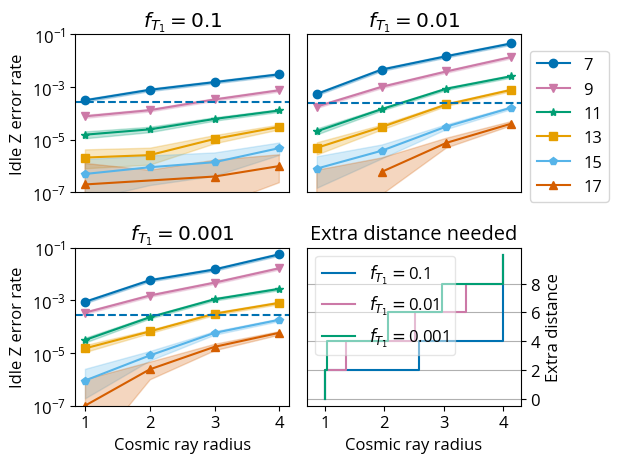

In [8]:
fig,ax = plt.subplots(2,2)

sinter.plot_error_rate(ax=ax[0,0], stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r']/2, group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: (x.json_metadata['strength'] == 0.9 and x.json_metadata['r'] > 0))
ax[0,0].axhline(baseline_error_rates[0, 0], linestyle='--')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Idle Z error rate')
ax[0,0].set_title(r'$f_{T_1} = 0.1$')
ax[0,0].set_ylim(1e-7, 1e-1)
ax[0,0].set_xticks([])

sinter.plot_error_rate(ax=ax[0,1], stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r']/2, group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: (x.json_metadata['strength'] == 0.99 and x.json_metadata['r'] > 0))
ax[0,1].axhline(baseline_error_rates[1,0], linestyle='--')
ax[0,1].set_yscale('log')
ax[0,1].set_title(r'$f_{T_1} = 0.01$')
ax[0,1].set_ylim(1e-7, 1e-1)
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].legend(bbox_to_anchor=(1.45, 0.95))

sinter.plot_error_rate(ax=ax[1,0], stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r']/2, group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: (x.json_metadata['strength'] == 0.999 and x.json_metadata['r'] > 0))
ax[1,0].axhline(baseline_error_rates[2,0], linestyle='--')
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Idle Z error rate')
ax[1,0].set_xlabel('Cosmic ray radius')
ax[1,0].set_title(r'$f_{T_1} = 0.001$')
ax[1,0].set_ylim(1e-7, 1e-1)

possible_extra_ds = np.array(d_range_mem)[1:] - d_range_mem[0]
smallest_radii = np.full((len(strengths_mem), len(possible_extra_ds)), np.inf)
for strength_idx in range(len(strengths_mem)):
    for baseline_d_idx,d in enumerate(d_range_mem):
        intersection_radii = intersections[strength_idx,baseline_d_idx,baseline_d_idx+1:]
        distances = np.array(d_range_mem[baseline_d_idx+1:])-d
        for i,(r,dist) in enumerate(zip(intersection_radii, distances)):
            if r < smallest_radii[strength_idx,i]:
                smallest_radii[strength_idx,i] = r
    
    ax[1,1].step([1] + list(smallest_radii[strength_idx]/2), [0] + list(possible_extra_ds), '-', label=r'$f_{T_1} =$'+f'{1-strengths_mem[strength_idx]:0.3g}')

    ax[1,1].set_title(f'Extra distance needed')
    ax[1,1].legend(framealpha=0.5)
    ax[1,1].set_ylabel('Extra distance')
    ax[1,1].yaxis.tick_right()
    ax[1,1].yaxis.set_label_position('right')
    ax[1,1].set_yticks([0,2,4,6,8])
    ax[1,1].grid(axis='y')
    ax[1,1].set_xlabel('Cosmic ray radius')
    ax[1,1].set_xlim(0.7,4.3)
plt.tight_layout()
# plt.savefig('../figures/expansion_distance_vs_radius.pdf', bbox_inches='tight')
plt.show()

# Lattice surgery: ray in center of merge area

In [9]:
generate_data = False

In [10]:
if generate_data:
    radii_surgery = [0,2,4,6,8]
    d_range_surgery = [7,9,11,13,15,17]
    strengths_surgery = [0.9, 0.99, 0.999]

    all_results = []
    for strength in strengths_surgery:
        results = []
        for radius in radii_surgery:
            op_list = []
            nmps = []
            for d in d_range_surgery:
                patch1 = MemoryPatch(d, d, d)
                patch1.init_reset_h_x = patch1.data
                patch1.init_reset_h_z = []
                patch2 = MemoryPatch(d, d, d, id_offset=2*d**2 - 1)
                patch2.init_reset_h_x = patch2.data
                patch2.init_reset_h_z = []
                op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.TOP, patch2, BoundaryType.BOTTOM, 4*d**2 - 2)])

                noise_params = GoogleNoiseParamsNoRandomRays.improve(10)
                noise_params.cosmic_ray_params.max_strength = strength
                nmp = NoiseModelPatch(op.patch_collection, noise_params, seed=0)
                if radius > 0:
                    nmp.force_cosmic_ray_by_coords((len(op.patch_collection.device)//2, len(op.patch_collection.device[0])//2), radius)
                op_list.append(op)
                nmps.append(nmp)
            results.append(get_processed_error_data(d_range_surgery, op_list=[[data] for data in zip(op_list, nmps)]))
        all_results.append(results)

    error_rates_surgery = np.zeros((len(strengths_surgery), len(radii_surgery), len(d_range_surgery)))
    for i,strength in enumerate(strengths_surgery):
        for j,subresult in enumerate(all_results[i]):
            for (d,radius_idx),result in subresult[0].items():
                error_rates_surgery[i, j+radius_idx, d_range_surgery.index(d)] = result['error_rate']

    pickle.dump({
            'radii': radii_surgery,
            'distances': d_range_surgery,
            'strengths': strengths_surgery,
            'raw_data': all_results,
            'processed_data': error_rates_surgery,
        }, 
        open('data/code_expansion_distance_surgery.pkl', 'wb')
    )
else:
    data = pickle.load(open('data/code_expansion_distance_surgery.pkl', 'rb'))
    radii_surgery = data['radii']
    d_range_surgery = data['distances']
    strengths_surgery = data['strengths']
    # all_results = data['raw_data']
    error_rates_surgery = data['processed_data']

In [11]:
# find radius at which each distance line crosses the baseline error rate
intersections = np.zeros((len(strengths_surgery), len(d_range_surgery), len(d_range_surgery)))
for strength_idx in range(len(strengths_surgery)):
    for baseline_d_idx,baseline_d in enumerate(d_range_surgery):
        baseline_error_rate = error_rates_surgery[strength_idx, 0, baseline_d_idx]
        for d_idx in range(len(d_range_surgery)):
            if np.all(error_rates_surgery[strength_idx, 1:, d_idx] < baseline_error_rate):
                intersections[strength_idx, baseline_d_idx, d_idx] = radii_surgery[-1]
            elif np.all(error_rates_surgery[strength_idx, 1:, d_idx] > baseline_error_rate):
                intersections[strength_idx, baseline_d_idx, d_idx] = radii_surgery[1]
            else:
                lower_radius_idx = np.argmax(np.cumsum(error_rates_surgery[strength_idx, 1:, d_idx] < baseline_error_rate))+1
                upper_radius_idx = lower_radius_idx+1

                x = radii_surgery[lower_radius_idx:upper_radius_idx+1]
                y = np.log10(error_rates_surgery[strength_idx, lower_radius_idx:upper_radius_idx+1, d_idx])
                
                assert y[0] < np.log10(baseline_error_rate) < y[1]
                slope, intercept = np.polyfit(x, y, 1)
                intersections[strength_idx, baseline_d_idx, d_idx] = (np.log10(baseline_error_rate) - intercept) / slope

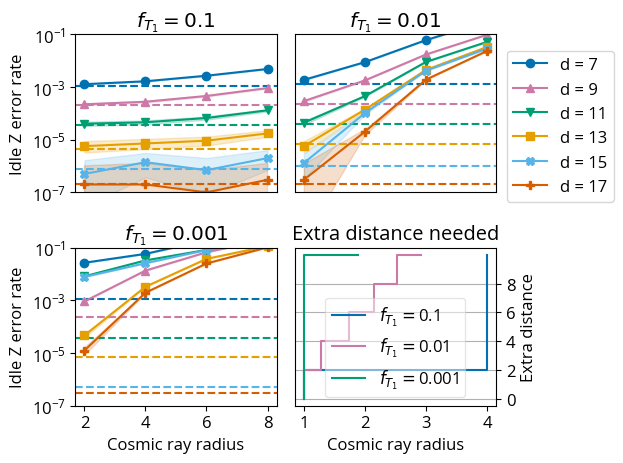

In [12]:
fig,ax = plt.subplots(2,2)

axis_coords = [(0,0), (0,1), (1,0)]

for i,(ax_coords,strength) in enumerate(zip(axis_coords, strengths_surgery)):
    axis = ax[ax_coords]

    for j,d in enumerate(d_range_surgery):
        axis.plot(radii_surgery[1:], error_rates_surgery[strengths_surgery.index(strength), 1:, j], label=f'd = {d}', color=f'C{j}')
        
        bounds = np.zeros((len(radii_surgery), 2))
        for k,radius in enumerate(radii_surgery):
            bounds[k] = qc_utils.stats.fit_binomial(num_shots=10**7, num_hits=int(error_rates_surgery[i, k, j]*10**7), max_likelihood_factor=1000)
        axis.fill_between(radii_surgery[1:], bounds[1:,0], bounds[1:,1], color=f'C{j}', alpha=0.2)

        for l in range(len(d_range_surgery)):
            if np.isfinite(intersections[i, j, l]):
                # axis.axvline(intersections[i, j, l], linestyle='--',
                # color=f'C{j}')
                pass

        axis.axhline(error_rates_surgery[strengths_surgery.index(strength), 0, j], linestyle='--', color=f'C{j}')

    # axis.axhline(baseline_error_rates[0, 0], linestyle='--')
    axis.set_yscale('log')
    if ax_coords[1] == 0:
        axis.set_ylabel('Idle Z error rate')
    else:
        axis.set_yticks([])

    if ax_coords[0] == 1:
        axis.set_xlabel('Cosmic ray radius')
    else:
        axis.set_xticks([])
    
    if i == 0:
        axis.set_title(r'$f_{T_1} = 0.1$')
    elif i == 1:
        axis.set_title(r'$f_{T_1} = 0.01$')
    elif i == 2:
        axis.set_title(r'$f_{T_1} = 0.001$')
    axis.set_ylim(1e-7, 1e-1)
    
    if ax_coords == (0,1):
        axis.legend(bbox_to_anchor=(1.01, 0.95))

    # axis.set_xlim(0, 8)

possible_extra_ds = np.array(d_range_surgery)[1:] - d_range_surgery[0]
smallest_radii = np.full((len(strengths_surgery), len(possible_extra_ds)), np.inf)
for strength_idx in range(len(strengths_surgery)):
    for baseline_d_idx,d in enumerate(d_range_surgery):
        intersection_radii = intersections[strength_idx,baseline_d_idx,baseline_d_idx+1:]
        distances = np.array(d_range_surgery[baseline_d_idx+1:])-d
        for i,(r,dist) in enumerate(zip(intersection_radii, distances)):
            if r < smallest_radii[strength_idx,i]:
                smallest_radii[strength_idx,i] = r

    ax[1,1].step([1] + list(smallest_radii[strength_idx]/2), [0] + list(possible_extra_ds), '-', label=r'$f_{T_1} =$'+f'{1-strengths_surgery[strength_idx]:0.3g}')

    ax[1,1].set_title(f'Extra distance needed')
    ax[1,1].legend(framealpha=0.5)
    ax[1,1].set_ylabel('Extra distance')
    ax[1,1].yaxis.tick_right()
    ax[1,1].yaxis.set_label_position('right')
    ax[1,1].set_yticks([0,2,4,6,8])
    ax[1,1].grid(axis='y')
    ax[1,1].set_xlabel('Cosmic ray radius')
    # ax[1,1].set_xlim(0.7,4.3)
plt.tight_layout()
# plt.savefig('../figures/expansion_distance_vs_radius.pdf', bbox_inches='tight')
plt.show()

# Combine f=0.1 memory with f=0.01 and f=0.001 lattice surgery (take worst error rate of the two)

In [13]:
# for 0.1, want memory. For other two, want surgery.

assert d_range_mem == d_range_surgery
assert strengths_mem == strengths_surgery
assert radii_mem == radii_surgery

combined_data = np.zeros((len(strengths_mem), len(radii_mem), len(d_range_mem)))
combined_data[0] = combined_error_rates_mem[0]
combined_data[1:] = error_rates_surgery[1:]

In [14]:
# find radius at which each distance line crosses the baseline error rate
intersections_combined = np.zeros((len(strengths_mem), len(d_range_mem), len(d_range_mem)))
for strength_idx in range(len(strengths_mem)):
    for baseline_d_idx,baseline_d in enumerate(d_range_mem):
        baseline_error_rate = combined_data[strength_idx, 0, baseline_d_idx]
        for d_idx in range(len(d_range_mem)):
            if np.all(combined_data[strength_idx, 1:, d_idx] < baseline_error_rate):
                intersections_combined[strength_idx, baseline_d_idx, d_idx] = radii_mem[-1]
            elif np.all(combined_data[strength_idx, 1:, d_idx] > baseline_error_rate):
                intersections_combined[strength_idx, baseline_d_idx, d_idx] = radii_mem[1]
            else:
                lower_radius_idx = np.argmax(np.cumsum(combined_data[strength_idx, 1:, d_idx] < baseline_error_rate))+1
                upper_radius_idx = lower_radius_idx+1

                x = radii_mem[lower_radius_idx:upper_radius_idx+1]
                y = np.log10(combined_data[strength_idx, lower_radius_idx:upper_radius_idx+1, d_idx])
                
                assert y[0] < np.log10(baseline_error_rate) < y[1]
                slope, intercept = np.polyfit(x, y, 1)
                intersections_combined[strength_idx, baseline_d_idx, d_idx] = (np.log10(baseline_error_rate) - intercept) / slope

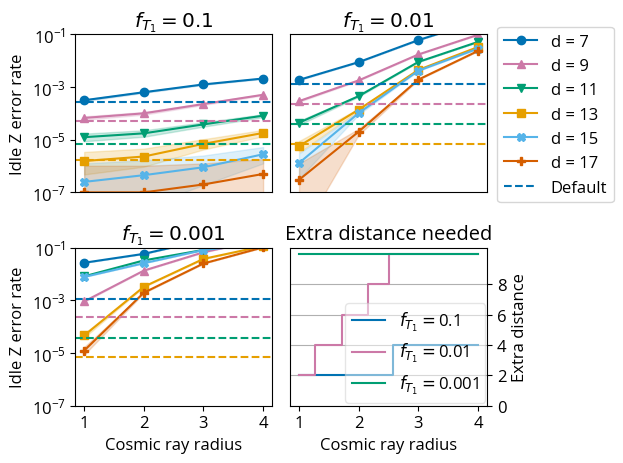

In [15]:
fig,ax = plt.subplots(2,2)

axis_coords = [(0,0), (0,1), (1,0)]

for i,(ax_coords,strength) in enumerate(zip(axis_coords, strengths_surgery)):
    axis = ax[ax_coords]

    for j,d in enumerate(d_range_surgery):
        axis.plot([r/2 for r in radii_surgery[1:]], combined_data[strengths_surgery.index(strength), 1:, j], label=f'd = {d}', color=f'C{j}')
        
        bounds = np.zeros((len(radii_surgery), 2))
        for k,radius in enumerate(radii_surgery):
            bounds[k] = qc_utils.stats.fit_binomial(num_shots=10**7, num_hits=int(combined_data[i, k, j]*10**7), max_likelihood_factor=1000)
        axis.fill_between([r/2 for r in radii_surgery[1:]], bounds[1:,0], bounds[1:,1], color=f'C{j}', alpha=0.2)

    for j,d in enumerate(d_range_surgery):
        if d <= 13:
            if ax_coords == (0,1) and j == 0:
                axis.axhline(combined_data[strengths_surgery.index(strength), 0, j], linestyle='--', color=f'C{j}', label='Default')
            else:
                axis.axhline(combined_data[strengths_surgery.index(strength), 0, j], linestyle='--', color=f'C{j}')

    # axis.axhline(baseline_error_rates[0, 0], linestyle='--')
    axis.set_yscale('log')
    if ax_coords[1] == 0:
        axis.set_ylabel('Idle Z error rate')
    else:
        axis.set_yticks([])

    if ax_coords[0] == 1:
        axis.set_xlabel('Cosmic ray radius')
        axis.set_xticks([1,2,3,4])
    else:
        axis.set_xticks([])
    
    if i == 0:
        axis.set_title(r'$f_{T_1} = 0.1$')
    elif i == 1:
        axis.set_title(r'$f_{T_1} = 0.01$')
    elif i == 2:
        axis.set_title(r'$f_{T_1} = 0.001$')
    axis.set_ylim(1e-7, 1e-1)
    
    if ax_coords == (0,1):
        axis.legend(bbox_to_anchor=(1.01, 1.1))

    # axis.set_xlim(0, 8)

possible_extra_ds = np.array(d_range_surgery)[1:] - d_range_surgery[0]
smallest_radii = np.full((len(strengths_surgery), len(possible_extra_ds)), np.inf)
for strength_idx in range(len(strengths_surgery)):
    for baseline_d_idx,d in enumerate(d_range_surgery):
        intersection_radii = intersections_combined[strength_idx,baseline_d_idx,baseline_d_idx+1:]
        distances = np.array(d_range_surgery[baseline_d_idx+1:])-d
        for i,(r,dist) in enumerate(zip(intersection_radii, distances)):
            if np.isfinite(r) and r < smallest_radii[strength_idx,i]:
                smallest_radii[strength_idx,i] = r

    ds = []
    for radius in np.linspace(2, 8, 100):

        if np.max(smallest_radii[strength_idx]) <= radius:
            radius = np.max(smallest_radii[strength_idx])-1e-10
        elif radius < np.min(smallest_radii[strength_idx]):
            extra_d = np.min(smallest_radii)
        nearest_larger_radius_idx = np.argmax(radius < smallest_radii[strength_idx])
        extra_d = possible_extra_ds[nearest_larger_radius_idx]
        ds.append(extra_d)

    # radii_to_plot = list(smallest_radii[strength_idx]/2)
    # ds_to_plot = list(possible_extra_ds)
    # print(radii_to_plot, ds_to_plot)
    # if radii_to_plot[0] != 1:
    #     radii_to_plot = [1] + radii_to_plot
    #     ds_to_plot = [ds_to_plot[0]] + ds_to_plot
    # if radii_to_plot[-1] != 4:
    #     radii_to_plot = radii_to_plot + [4]
    #     ds_to_plot = ds_to_plot + [ds_to_plot[-1]]

    # print(radii_to_plot, ds_to_plot)

    # ax[1,1].step(radii_to_plot, ds_to_plot, '-', label=r'$f_{T_1} =$'+f'{1-strengths_surgery[strength_idx]:0.3g}', where='post')

    ax[1,1].step(np.linspace(1, 4, 100), ds, '-', label=r'$f_{T_1} =$'+f'{1-strengths_surgery[strength_idx]:0.3g}')

    ax[1,1].set_title(f'Extra distance needed')
    ax[1,1].legend(framealpha=0.5, loc=(0.28, 0.02))
    ax[1,1].set_ylabel('Extra distance')
    ax[1,1].yaxis.tick_right()
    ax[1,1].yaxis.set_label_position('right')
    ax[1,1].set_yticks([0,2,4,6,8])
    ax[1,1].set_xticks([1,2,3,4])
    ax[1,1].grid(axis='y')
    ax[1,1].set_xlabel('Cosmic ray radius')
    # ax[1,1].set_xlim(0.7,4.3)
plt.tight_layout()
plt.savefig('../figures/expansion_distance_vs_radius.pdf', bbox_inches='tight')
plt.show()

In [16]:
# save this data to use elsewhere when calculating overheads

with open('data/code_expansion_distance_processed.pkl', 'wb') as f:
    pickle.dump({
        'possible_extra_ds': possible_extra_ds,
        'smallest_radii': smallest_radii,
        'strengths': strengths_mem,
    }, f)

In [17]:
smallest_radii

array([[5.169925  , 8.        , 8.        , 8.        , 8.        ],
       [2.5722833 , 3.46926187, 4.30872419, 5.05519259, 5.82700888],
       [2.        , 2.        , 2.        , 2.        , 3.79011505]])